In [2]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [3]:
from helpers import load_data, preprocess_data

path_dataset = "movielens100k.csv"
ratings = load_data(path_dataset)

number of items: 1682, number of users: 943


### Plot the number of ratings per movie and user

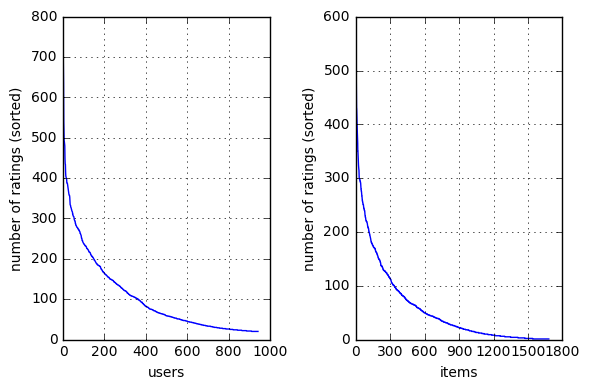

min # of items per user = 20, min # of users per item = 1.


In [4]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [13]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    num_rows, num_cols = valid_ratings.shape 
    train = sp.lil_matrix((num_rows, num_cols)) 
    test = sp.lil_matrix((num_rows, num_cols)) 
    
    nz_items, nz_users, _ = sp.find(valid_ratings)
    
    for u in set(nz_users): 
        row, col, _ = sp.find(valid_ratings[:, u])
        test_rows = np.random.choice(row, int(len(row) * p_test)) 
        train_rows = list(set(row) - set(test_rows)) 
        # add to train 
        train[train_rows, u] = valid_ratings[train_rows, u] 
        # add to test 
        test[test_rows, u] = valid_ratings[test_rows, u] 
    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

Total number of nonzero elements in origial data:99999
Total number of nonzero elements in train data:88954
Total number of nonzero elements in test data:8998


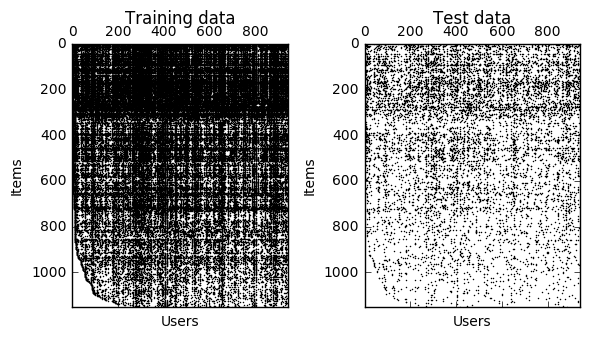

In [174]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
plot_train_test_data(train, test)

## Implementing Baselines 

### Use the global mean to do the prediction

In [9]:
from helpers import calculate_mse

def baseline_global_mean(train, test):
    """baseline method: use the global mean."""
    err = valid_ratings.todense() - valid_ratings.mean()
    rmse = np.mean(0.5*(np.power(err,2)))
    print(rmse)

baseline_global_mean(train, test)

0.571962858715


### Use the user means as the prediction

In [31]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    err = valid_ratings - valid_ratings.mean(axis=1)
    rmse = np.mean(0.5*(np.power(err,2)))
    print(rmse)

baseline_user_mean(train, test)

0.508900104306


### Use the item means as the prediction

In [32]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    err = valid_ratings.T - valid_ratings.mean(axis=0).T
    rmse = np.mean(0.5*(np.power(err,2)))
    print(rmse)
    
baseline_item_mean(train, test)

0.529638378777


### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

In [15]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    num_user = train.shape[1]
    num_item = train.shape[0]
    user_features = np.random.rand(num_features,num_user) # user_features shape (20,943)
    item_features = np.random.rand(num_item, num_features) # item_features shape (1152,20)
    return user_features, item_features

Compute the cost by the method of matrix factorization.

In [16]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    sum_err = 0
    for d, n in nz:
        err = data[d,n] - np.dot(item_features[d,:],user_features[:,n])
        sum_err += err**2
    rmse = 0.5*sum_err/len(nz)
    return rmse

In [17]:
def matrix_factorization_SGD(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.01
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    num_epochs = 20     # number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        for d, n in nz_train: # iterate over non zero elements
            e_dn = train[d,n] - np.dot(item_features[d,:],user_features[:,n])
            # subtract the gradient for each feature
            for k in range(num_features):
                user_features[k,n] = user_features[k,n] + gamma * e_dn * item_features[d,k] #- lambda_user * user_features[k,n]  
                item_features[d,k] = item_features[d,k] + gamma * e_dn * user_features[k,n] #- lambda_item * item_features[d,k]
        rmse = compute_error(train, user_features, item_features, nz_train)

        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        errors.append(rmse)
    # evaluate the test error
    rmse = compute_error(test, user_features, item_features, nz_test)
    print("RMSE on test data: {}.".format(rmse))

matrix_factorization_SGD(train, test)   

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 0.49003580242806516.
iter: 1, RMSE on training set: 0.4428323576951461.
iter: 2, RMSE on training set: 0.42239306074282257.
iter: 3, RMSE on training set: 0.40965081366711303.
iter: 4, RMSE on training set: 0.4009306541102881.
iter: 5, RMSE on training set: 0.39465859048361557.
iter: 6, RMSE on training set: 0.3895712976429535.
iter: 7, RMSE on training set: 0.385674878448942.
iter: 8, RMSE on training set: 0.3825121066990484.
iter: 9, RMSE on training set: 0.37999340933749043.
iter: 10, RMSE on training set: 0.3779525365018698.
iter: 11, RMSE on training set: 0.3762478763229114.
iter: 12, RMSE on training set: 0.37488806039876055.
iter: 13, RMSE on training set: 0.3737453394535974.
iter: 14, RMSE on training set: 0.3728053694207582.
iter: 15, RMSE on training set: 0.3720307204243492.
iter: 16, RMSE on training set: 0.3713836385850843.
iter: 17, RMSE on training set: 0.3708486286608121.
iter: 18, RMSE on trainin

### Learn the Matrix Factorization using Alternating Least Squares

In [169]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    
    

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    

In [211]:
from helpers import build_index_groups


def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    change = 1
    error_list = [0, 0]
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    user_features = np.matrix(user_features) # convert ndarray into matrix for subsequent operations
    item_features = np.matrix(item_features)
    
    item_features[:,0] = train.mean(axis=1) #Initialize the item matrix by assigning the average rating as the first row
    num_epochs = 10;
    nz_train, nz_item_userindices, nz_user_itemindices = build_index_groups(train)
    
    for it in range(num_epochs):
        print("starting iter: {}".format(it))
        
        # fix item_features and estimate user_features
        for d, user_d in enumerate(nz_user_itemindices): # iterate over non zero users
            #nnz_items_per_user = len(user_d[1]) # Number of items user d has rated
            #if (nnz_items_per_user == 0): nnz_items_per_user = 1
            # Least squares solution
            A_d = np.dot(item_features[user_d[1]].T, item_features[user_d[1]]) #+lambda_user*nnz_items_per_user*E
            V_d = np.dot(item_features[user_d[1]].T, train[user_d[1],user_d[0]].todense())
            user_features[:,user_d[0]] = np.linalg.solve(A_d,V_d)

        # fix user_features and estimate item_features
        for n, item_n in enumerate(nz_item_userindices):
            # Least squares solution
            A_n = np.dot(user_features[:,item_n[1]], user_features[:,item_n[1]].T) #+ lambda_user * nnz_items_per_user * E
            V_n = np.dot(user_features[:,item_n[1]], train.T[item_n[1],item_n[0]].todense())
            item_features.T[:,item_n[0]] = np.linalg.solve(A_n,V_n)
        
        rmse = compute_error(train, user_features, item_features, nz_train)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        #if e < stop_criterion:
            #break
        

ALS(train, test)

starting iter: 0
iter: 0, RMSE on training set: [[ 0.2624819]].
starting iter: 1
iter: 1, RMSE on training set: [[ 0.217119]].
starting iter: 2
iter: 2, RMSE on training set: [[ 0.19915314]].
starting iter: 3
iter: 3, RMSE on training set: [[ 0.18884879]].
starting iter: 4
iter: 4, RMSE on training set: [[ 0.18193574]].
starting iter: 5
iter: 5, RMSE on training set: [[ 0.17697262]].
starting iter: 6
iter: 6, RMSE on training set: [[ 0.17323449]].
starting iter: 7
iter: 7, RMSE on training set: [[ 0.17014154]].
starting iter: 8
iter: 8, RMSE on training set: [[ 0.16757378]].
starting iter: 9
iter: 9, RMSE on training set: [[ 0.16535913]].
